In [13]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.classifications import aggregate_data_stats as aggr

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D


In [5]:
%matplotlib notebook


# Set color schemes by visual area

In [6]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

In [7]:
def set_split_xlabels(ax, offset=0.25, a_label='rfs', b_label='rfs10'):
    ax.set_xticks([0-offset, 0+offset, 1-offset, 1+offset, 2-offset, 2+offset])
    ax.set_xticklabels([a_label, b_label, a_label, b_label, a_label, b_label])
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(bottom=True, offset=4)
    return ax

# Set dataset parameters

In [8]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s-%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
data_desc = '%s-%s' % (traceid, fit_desc)
data_id = '|'.join([data_desc, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff
DATA ID: traces001-fit-2dgaus_dff-no-cutoff|fit-2dgaus_dff-no-cutoff-thr-0.50


# Control: check 'rfs' vs. 'rfs10'

In [9]:
#### Create current output dir
compare_dir = os.path.join(outdir, 'general-stats', 'rfs_v_rfs10')
if not os.path.exists(compare_dir):
    os.makedirs(compare_dir)
print compare_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10


#### Load data

In [10]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [11]:
# Get data sets where rfs and rfs10 were tested
ctl_dsets = pd.concat([dg[dg['experiment'].isin(['rfs', 'rfs10'])] for dkey, dg in sdata.groupby(['animalid', 'session', 'fovnum']) \
            if 'rfs' in dg['experiment'].values and 'rfs10' in dg['experiment'].values], axis=0).reset_index(drop=True)
ctl_dsets.groupby(['visual_area'])['experiment'].value_counts()

visual_area  experiment
Li           rfs           4
             rfs10         4
Lm           rfs           1
             rfs10         1
V1           rfs           4
             rfs10         4
Name: experiment, dtype: int64

In [22]:
# Aggregate all fit data into dataframe
scale_sigma = True

dpaths, _ = rfutils.get_fit_dpaths(ctl_dsets, fit_desc=fit_desc, traceid=traceid,) # get datapths
tmpdf = rfutils.aggregate_rf_data(dpaths,  fit_desc=fit_desc, traceid=traceid,
                                  fit_thr=fit_thr, scale_sigma=scale_sigma, verbose=False) # load dataframes
df = tmpdf[tmpdf['r2']>fit_thr] # Filter to make sure all good fits

df.groupby(['visual_area', 'experiment']).count()


N dpaths: 18, N unfit: 0
N datasets included: 18, N sessions excluded: 0


r2  sigma_x  sigma_y  theta   x0   y0  animalid  \
visual_area experiment                                                     
Li          rfs          57       57       57     57   57   57        57   
            rfs10       129      129      129    129  129  129       129   
Lm          rfs          11       11       11     11   11   11        11   
            rfs10        20       20       20     20   20   20        20   
V1          rfs         254      254      254    254  254  254       254   
            rfs10       387      387      387    387  387  387       387   

                        cell  datakey  session  avg_size  
visual_area experiment                                    
Li          rfs           57       57       57        57  
            rfs10        129      129      129       129  
Lm          rfs           11       11       11        11  
            rfs10         20       20       20        20  
V1          rfs          254      254      254       254  
            rfs10        387      387      387       387

In [116]:
df.shape

(858, 15)

In [21]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

## Check size of RFs by x/y

In [23]:
fx = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.cos(df['theta']))
fy = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy

<IPython.core.display.Javascript object>


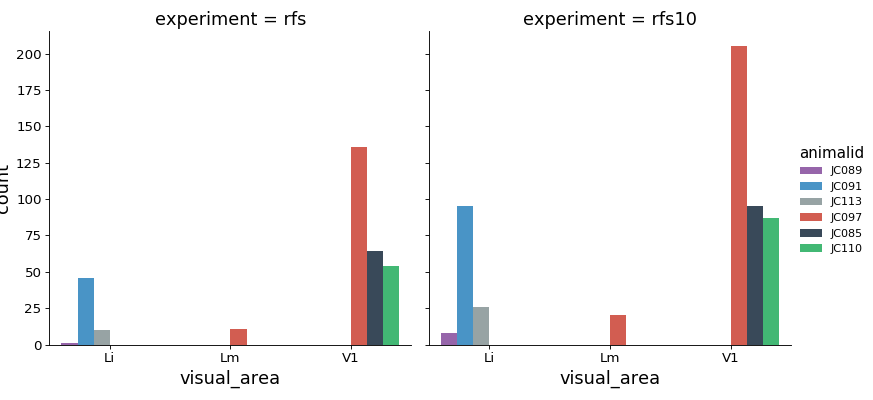

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,session,avg_size,fx,fy
visual_area,,,,,,,,,,,,,,
Li,186,186,186,186,186,186,186,186,186,186,186,186,186,186
Lm,31,31,31,31,31,31,31,31,31,31,31,31,31,31
V1,641,641,641,641,641,641,641,641,641,641,641,641,641,641


In [44]:
sns.catplot(x='visual_area', hue='animalid', col='experiment',  data=df, kind='count')
df.groupby(['visual_area']).count()

## Get x + y components of vector spanned by ellipse (major)

In [33]:
datakey = '20190622_JC085_fov1'
rid=25

params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
df[(df['datakey']==datakey) & (df['cell']==rid)][params]

,r2,sigma_x,sigma_y,theta,x0,y0,datakey,cell,experiment,avg_size,fx,fy
10,0.521895,27.025101,19.062105,0.534488,36.057414,-0.171032,20190622_JC085_fov1,25,rfs,23.043603,11.627953,6.883294
10,0.689377,27.800128,20.045584,4.158936,36.463372,-4.939850,20190622_JC085_fov1,25,rfs10,23.922856,7.306262,11.824987


237.777484979


<IPython.core.display.Javascript object>


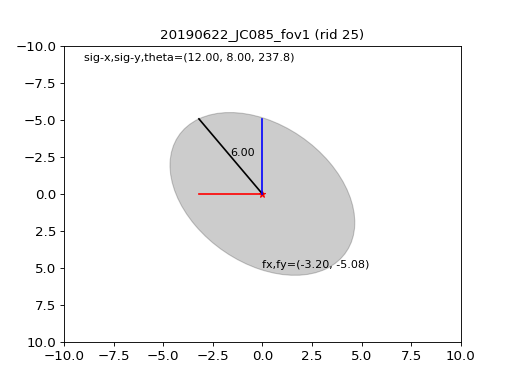

(-3.2, -5.08)


In [34]:
from matplotlib.patches import Ellipse

x0, y0 = (0, 0)
M = 12 #10
m = 8 #3
theta = np.rad2deg(4.15)
print(theta)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.

xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)
print(fx, fy)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')


ax.set_title('%s (rid %i)' % (datakey, rid))

ax.invert_yaxis()

## Plot x- and y-components of fit RFs

<IPython.core.display.Javascript object>


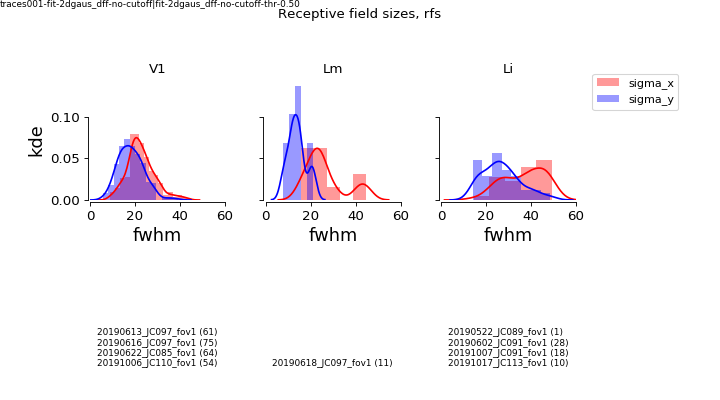

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'split_sigma_xy_fwhm_rfs')


In [45]:
split_components = False
experiment = 'rfs'

x_color = 'r'
y_color = 'b'

_df = df[df['experiment']==experiment].copy()

sigma_str = 'fwhm' if scale_sigma else 'sigma'
xlim = 60 if scale_sigma else 30
sz_metric = 'f' if split_components else 'sigma_'

visual_areas = ['V1', 'Lm', 'Li']
offset=0
fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.5)

for ax, visual_area in zip(axes.flat, visual_areas):
    g = _df[_df['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % sz_metric], color=x_color, ax=ax, label='%sx' % sz_metric)
    sns.distplot(g['%sy' % sz_metric], color=y_color, ax=ax, label='%sy' % sz_metric)
    ax.set_title(visual_area)
    count_str = '\n'.join(['%s (%i)' % (dkey, len(d)) for dkey, d in g.groupby(['datakey'])])
    #ax.set_ylim([0, 0.1])
    ax.set_xlim([0, xlim])
    ax.text(3, -0.2, count_str, fontsize=8)
    
    if scale_sigma:
        ax.set_xlabel('fwhm')
    else:
        ax.set_xlabel('sigma')

sns.despine(trim=True, offset=2)
    
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('Receptive field sizes, %s' % experiment)

figname = 'split_%sxy_%s_%s' % (sz_metric, sigma_str, experiment)
pl.savefig(os.path.join(compare_dir, '%s_2.svg' % figname))
print(compare_dir, figname)

## Average size by experiment-type (all fovs tested for control)

<IPython.core.display.Javascript object>


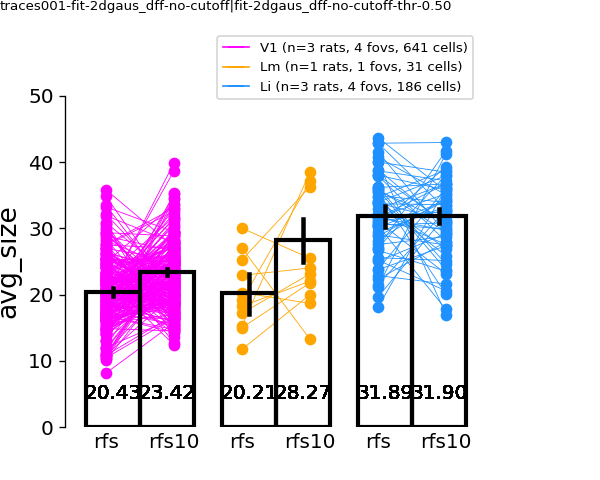

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'avg_size_fwhm_xy_by-area')


In [197]:
curr_metric = 'avg_size'

offset = 0.25
marker= 'o'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)


ax = pairwise_compare_single_metric(df, curr_metric=curr_metric, ax=ax)

# Set x labels
ax.set_ylim([0, 50])

df.apply(annotateBars, ax=ax, axis=1)
    
# Set x labels
ylim = 50 if scale_sigma else 30
ax.set_ylim([0, ylim])
set_split_xlabels(ax, a_label='rfs', b_label='rfs10')


pl.subplots_adjust(left=0.12, right=0.8, top=0.8)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = get_counts_for_legend(df, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


figname = '%s_%s_xy_by-area' % (curr_metric, sigma_str)

pl.savefig(os.path.join(compare_dir, '%s_2.svg' % figname))

print(compare_dir, figname)

# Get cells fit for BOTH rfs and rfs10

In [54]:
common_rois = dict((dkey, np.intersect1d(d[d['experiment']=='rfs']['cell'], d[d['experiment']=='rfs10']['cell']))\
                     for dkey, d in df.groupby(['datakey']))

comdf = []
for visual_area, vdf in df.groupby(['visual_area']):
    currdf = pd.concat([g[g['cell'].isin(common_rois[dkey])] \
                        for dkey, g in vdf.groupby(['datakey'])], axis=0)

    a_vals = currdf[currdf['experiment']=='rfs']['avg_size']
    b_vals = currdf[currdf['experiment']=='rfs10']['avg_size']

    comdf.append(currdf)
    print("-----%s-------------------------" % visual_area)
    print("Paired t-test:")
    print spstats.ttest_rel(a_vals, b_vals) # Paired ttest (repeated measures)
    
    print("Wilcozon signed-rank (not assuming Gaussian):")
    print spstats.wilcoxon(a_vals, b_vals)   
    
comdf = pd.concat(comdf, axis=0)

-----Li-------------------------
Paired t-test:
Ttest_relResult(statistic=-2.0238834455616597, pvalue=0.05228210758740956)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=108.0, pvalue=0.010444400581851145)
-----Lm-------------------------
Paired t-test:
Ttest_relResult(statistic=-1.619210183233768, pvalue=0.1663270470773888)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=5.0, pvalue=0.24886387493792206)
-----V1-------------------------
Paired t-test:
Ttest_relResult(statistic=-7.0054593224410526, pvalue=3.8516747073728414e-11)
Wilcozon signed-rank (not assuming Gaussian):
WilcoxonResult(statistic=4588.0, pvalue=1.1602391906359055e-10)


In [55]:
comdf.head()

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,session,visual_area,avg_size,fx,fy
0,0.745698,27.939596,17.839856,0.109926,29.626002,-6.651742,JC091,16,20190602_JC091_fov1,rfs,20190602,Li,22.889726,13.885480,1.532549
1,0.703492,23.204377,26.883007,1.811255,31.887327,-7.297954,JC091,33,20190602_JC091_fov1,rfs,20190602,Li,25.043692,3.201072,13.054775
2,0.657171,38.301180,26.031808,0.134737,33.680634,-8.699873,JC091,34,20190602_JC091_fov1,rfs,20190602,Li,32.166494,18.977023,2.572491
4,0.652976,40.019134,23.407070,0.233049,32.226918,-4.272079,JC091,37,20190602_JC091_fov1,rfs,20190602,Li,31.713102,19.468644,4.621110
5,0.680329,46.021449,39.803172,0.544099,45.646154,-21.471942,JC091,295,20190602_JC091_fov1,rfs,20190602,Li,42.912310,19.687843,11.911436


In [56]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

formula = 'avg_size ~ C(experiment) * C(visual_area)'
model = ols(formula, data=comdf).fit()
aov_table = sm.stats.anova_lm(model, typ=3)
aov_table

,sum_sq,df,F,PR(>F)
Intercept,29956.717229,1.0,1310.099701,1.071929e-136
C(experiment),127.771289,1.0,5.587833,1.850035e-02
C(visual_area),3201.563710,2.0,70.007131,2.865097e-27
C(experiment):C(visual_area),3.287336,2.0,0.071883,9.306505e-01
Residual,10518.352091,460.0,NaN,NaN


In [57]:
model = ols('avg_size ~ visual_area + experiment', comdf).fit()
print(model.summary()) 

                            OLS Regression Results                            
Dep. Variable:               avg_size   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.410
Method:                 Least Squares   F-statistic:                     108.9
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           2.53e-53
Time:                        16:50:18   Log-Likelihood:                -1387.5
No. Observations:                 466   AIC:                             2783.
Df Residuals:                     462   BIC:                             2800.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              31.5719    

In [58]:
print(model.f_test([0, 1, -1, 0]))

<F test: F=array([[ 6.62733246]]), p=0.0103529201469, df_denom=462, df_num=1>


In [59]:
result = ols(formula='avg_size ~ visual_area + experiment + visual_area * experiment', data=comdf).fit()    
print(result.summary())    

                            OLS Regression Results                            
Dep. Variable:               avg_size   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     65.09
Date:                Wed, 15 Jul 2020   Prob (F-statistic):           2.58e-51
Time:                        16:50:18   Log-Likelihood:                -1387.4
No. Observations:                 466   AIC:                             2787.
Df Residuals:                     460   BIC:                             2812.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [60]:
# def annotateBars(row, ax=ax, fontsize=12): 
#     for p in ax.patches:
#         ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 0.), #p.get_height()),
#                     ha='center', va='center', fontsize=fontsize, color='k', 
#                     rotation=0, xytext=(0, 20),
#              textcoords='offset points')
        
    

In [131]:
def pairwise_compare_single_metric(comdf, curr_metric='avg_size', ax=None, marker='o'):

    offset = 0.25
    
    if ax is None:
        fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
        fig.patch.set_alpha(0)
        ax.patch.set_alpha(0)
    
    # Plot paired values
    aix=0
    for ai, visual_area in enumerate(visual_areas):

        plotdf = comdf[comdf['visual_area']==visual_area]
        a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
        b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

        by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
        for pi, p in enumerate(by_exp):
            ax.plot([aix-offset, aix+offset], p, marker=marker, color=area_colors[visual_area], 
                    alpha=1, lw=0.5,  zorder=0, markerfacecolor=None, markeredgecolor=area_colors[visual_area])
        tstat, pval = spstats.ttest_rel(a_vals, b_vals)
        print("%s: (t-stat:%.2f, p=%.2f)" % (visual_area, tstat, pval))
        aix = aix+1

    # Plot average
    sns.barplot("visual_area", curr_metric, data=comdf, 
                hue='experiment', #zorder=0,
                ax=ax, order=visual_areas,
                errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
    ax.legend_.remove()

    set_split_xlabels(ax, a_label='rfs', b_label='rfs10')
    
    return ax


In [66]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

<IPython.core.display.Javascript object>


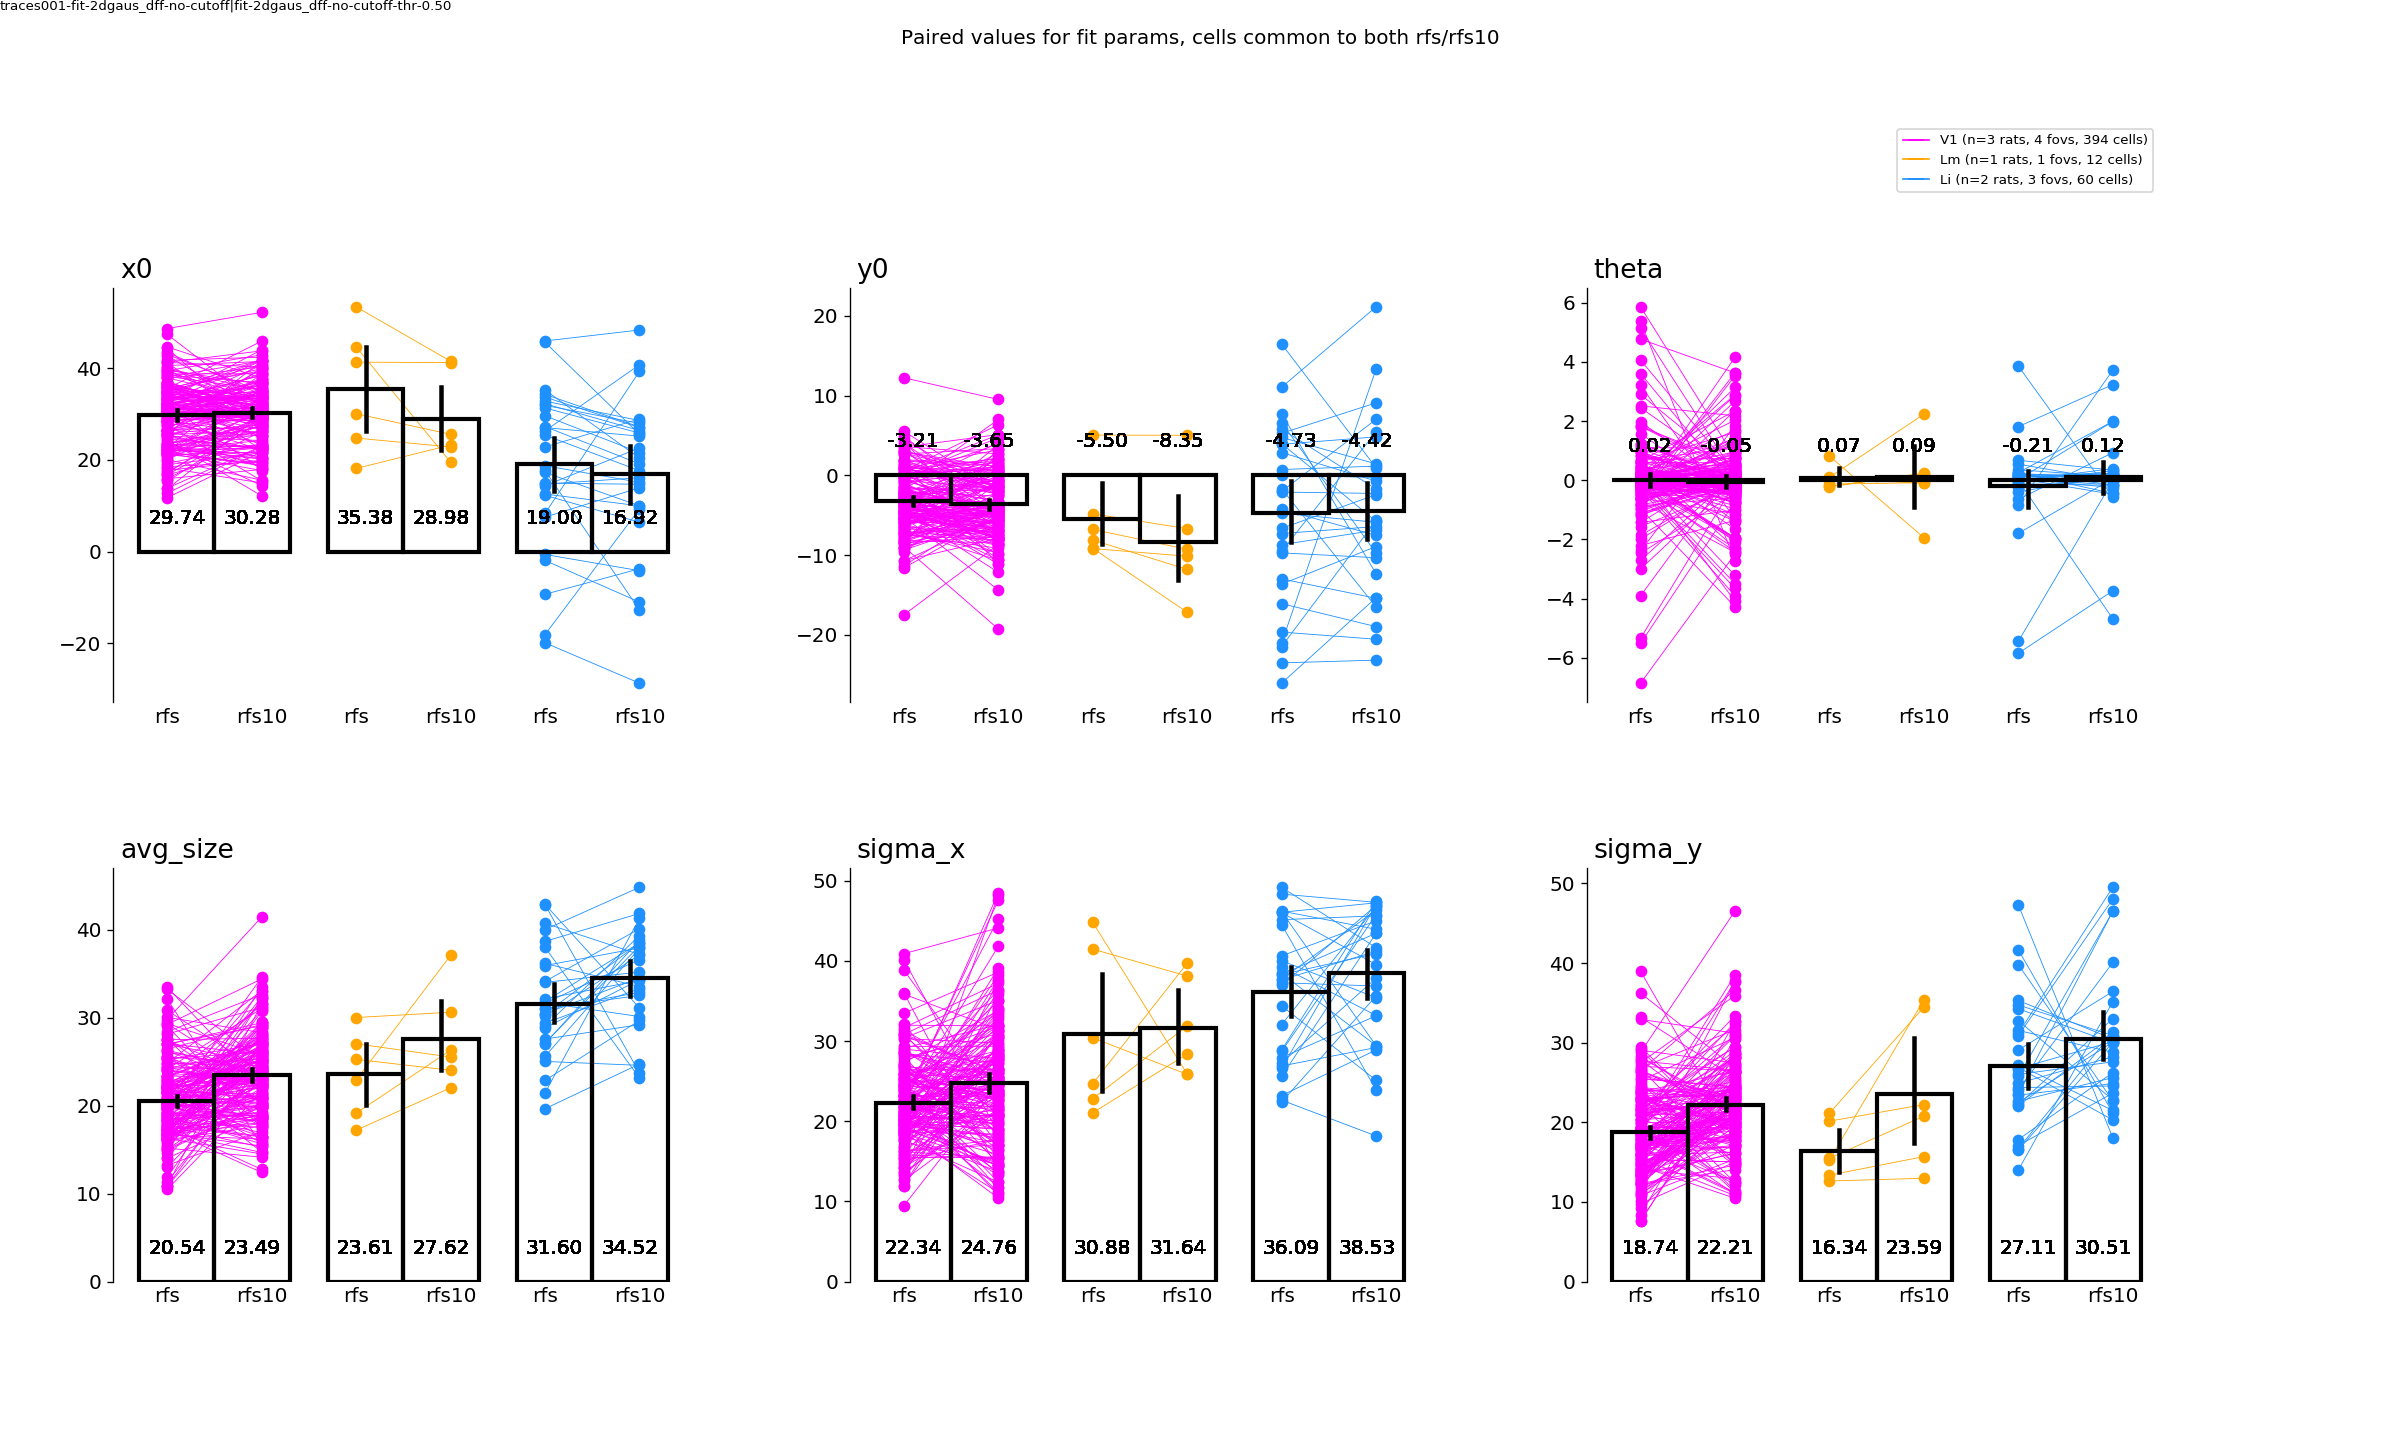

x0--------------
V1: (t-stat:-1.18, p=0.24)
Lm: (t-stat:1.46, p=0.20)
Li: (t-stat:0.95, p=0.35)
y0--------------
V1: (t-stat:1.42, p=0.16)
Lm: (t-stat:2.46, p=0.06)
Li: (t-stat:-0.16, p=0.87)
theta--------------
V1: (t-stat:0.55, p=0.58)
Lm: (t-stat:-0.03, p=0.98)
Li: (t-stat:-0.92, p=0.37)
avg_size--------------
V1: (t-stat:-7.01, p=0.00)
Lm: (t-stat:-1.62, p=0.17)
Li: (t-stat:-2.02, p=0.05)
sigma_x--------------
V1: (t-stat:-3.84, p=0.00)
Lm: (t-stat:-0.15, p=0.88)
Li: (t-stat:-1.30, p=0.20)
sigma_y--------------
V1: (t-stat:-6.75, p=0.00)
Lm: (t-stat:-2.27, p=0.07)
Li: (t-stat:-1.48, p=0.15)
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'fitparams_cells-common-to-both-condns_sigma_xy_fwhm')


In [76]:
split_components = False

offset = 0.25
marker= 'o'

params = ['x0', 'y0', 'theta', 'avg_size']
sz_metric = 'f' if split_components else 'sigma_'
params.extend(['%sx' % sz_metric, '%sy' % sz_metric])
    

fig, axn = pl.subplots(2, 3, figsize=(20,12), dpi=dpi)
fig.patch.set_alpha(0)

for ax, curr_metric in zip(axn.flat, params):

    ax.patch.set_alpha(0)
    
    # Plot paired values
    print("%s--------------" % curr_metric)
    ax = pairwise_compare_single_metric(comdf, curr_metric=curr_metric, ax=ax)
    
    ax.set_title(curr_metric, loc='left', fontsize=16)
    ax.set_ylabel('')

    # Annotate bars
    comdf.apply(aggr.annotateBars, ax=ax, axis=1)
    
# Adjust figure size
pl.subplots_adjust(left=0.05, right=0.9, top=0.8, wspace=0.3, hspace=0.4)
label_figure(fig, data_id)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1, 2.8), fontsize=8)

fig.suptitle('Paired values for fit params, cells common to both rfs/rfs10')

# Save
figname = 'fitparams_cells-common-to-both-condns_%sxy_%s' % (sz_metric, sigma_str)
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

print(compare_dir, figname)    

In [124]:
# curr_metric = 'avg_size'

# fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
# fig.patch.set_alpha(0)
# ax.patch.set_alpha(0)

# ax = pairwise_compare_single_metric(comdf, curr_metric='avg_size', ax=ax)

# # Set x labels
# ax.set_ylim([0, 50])
    
# # Adjust figure size
# pl.subplots_adjust(left=0.12, right=0.7, top=0.8)
# label_figure(fig, data_id)

# # Get counts of samples for legend
# legend_elements = aggr.get_counts_for_legend(comdf, area_colors=area_colors, markersize=10, marker='_')
# ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)

# # Save
# # figname = '%s_cells-common-to-both-condns' % curr_metric
# # pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))

# # print(compare_dir, figname)    

# Check counts (N cells fit by experiment type)

In [121]:
countdf_all = df.groupby([ 'experiment', 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf_all.rename(columns={'cell': 'n_cells'}, inplace=True)


curr_metric = 'n_cells'

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

ax = pairwise_compare_single_metric(countdf_all, curr_metric=curr_metric, ax=ax)

# Set x labels
#ax.set_ylim([0, 50])

#### Plot join between rfs/rfs10

<IPython.core.display.Javascript object>


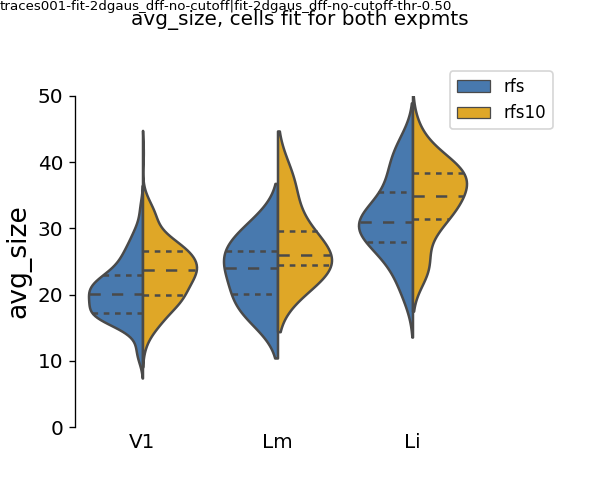

In [77]:
curr_metric = 'avg_size'

ylim = 50 if scale_sigma else 30
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.violinplot(x='visual_area', y=curr_metric, data=comdf, ax=ax,
               order=visual_areas,
              hue='experiment', palette=bi_palette, split=True,
               inner='quartile', scale='count')

ax.set_ylim([0, ylim])
ax.tick_params(axis='x', size=0)
ax.set_xlabel('')

fig.suptitle('%s, cells fit for both expmts' % curr_metric)
pl.subplots_adjust(right=0.8, top=0.8)
label_figure(fig, data_id)

ax.legend(bbox_to_anchor=(1.2, 1.1))
sns.despine(bottom=True, trim=True)

#### Calculate difference between rfs/rfs10 for size

In [125]:
# diffs = []
# for v, vdf in comdf.groupby(['visual_area']):
#     a_vals = vdf[vdf['experiment']=='rfs'][curr_metric].values
#     b_vals = vdf[vdf['experiment']=='rfs10'][curr_metric].values
#     diffs.append(pd.DataFrame({'visual_area': [v for _ in np.arange(0, len(a_vals))],
#                                'difference': b_vals - a_vals}))
# diffs = pd.concat(diffs, axis=0)


# fig, ax = pl.subplots()
# sns.stripplot(x='visual_area', y='difference', data=diffs,
#               order=visual_areas, palette=area_colors, ax=ax)

In [80]:
params = ['x0', 'y0', 'theta', 'sigma_x', 'sigma_y', 'avg_size']

<IPython.core.display.Javascript object>


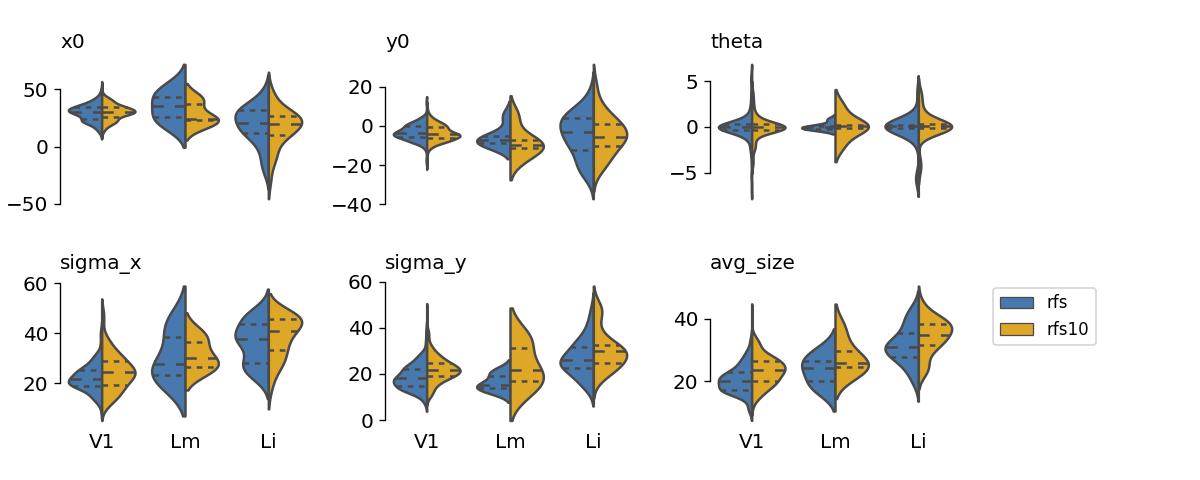

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'all-metrics_cells-common-to-both-condns_fwhm')


In [81]:
currcols = ['windows blue', 'amber']
bi_palette = sns.xkcd_palette(currcols)

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    sns.violinplot(x='visual_area', y=param, data=comdf, ax=ax,
                   order=visual_areas,
                  hue='experiment', palette=bi_palette, split=True,
                   scale='count', inner='quartile')
    if ai < 5:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1.1, 1))
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_cells-common-to-both-condns_%s' % sigma_str
pl.savefig(os.path.join(compare_dir, '%s_2svg' % figname))

print(compare_dir, figname)    

In [83]:
reload(aggr)
reload(ret)

<module 'pipeline.python.classifications.retino_structure' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/retino_structure.pyc'>

# Visualize general stats

In [82]:
scale_sigma = True


### Check size distns for ALL dataset

In [91]:
# set output dir
filter_by = 'drop_repeats'
genstats_dir = os.path.join(outdir, 'general-stats', filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print genstats_dir

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats


In [89]:
filter_by = None

#### Get metadata
r_df_nof, dkey_dict_nof = rfutils.aggregate_rf_dataframes(filter_by, traceid=traceid, 
                                                          fov_type=fov_type, state=state, stimulus='rfs')

# dsets_nof = aggr.get_metadata(traceid=traceid, fov_type=fov_type, state=state, 
#                               filter_by=filter_by, stimulus='rfs')
# rfdata_nof = dsets_nof[dsets_nof['experiment'].isin(['rfs', 'rfs10'])].copy()

# #### Check for any datasets that need RF fits
# excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
#                      'JC080_20190602_FOV1_zoom2p0x',
#                      'JC113_20191108_FOV1_zoom2p0x', 'JC113_20191108_FOV2_zoom2p0x']
# rf_dpaths_nof, _ = rfutils.get_fit_dpaths(rfdata_nof, traceid=traceid, fit_desc=fit_desc, 
#                                           excluded_sessions=excluded_sessions)

# #### Get RF dataframe for all datasets (filter to include only good fits)
# all_df_nof = rfutils.aggregate_rf_data(rf_dpaths_nof, scale_sigma=scale_sigma, verbose=False,
#                                       fit_desc=fit_desc, traceid=traceid)
# all_df_nof.groupby(['visual_area', 'experiment'])['datakey'].count()

# #### Filter for good fits only
# r_df_nof= all_df_nof[all_df_nof['rvisual_areas = ['V1', 'Lm', 'Li']
# colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
# 2'] > fit_thr].copy().reset_index(drop=True)
# dkey_dict_nof = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
#                  for v, vdf in r_df_nof.groupby(['visual_area'])) 
# r_df_nof['datakey_ix'] = [dkey_dict_nof[r_df_nof['visual_area'][i]][r_df_nof['datakey'][i]] \
#                       for i in r_df_nof.index.tolist()]    
    
    

Selecting 63 dsets
N dpaths: 70, N unfit: 0
N datasets included: 70, N sessions excluded: 4


<IPython.core.display.Javascript object>


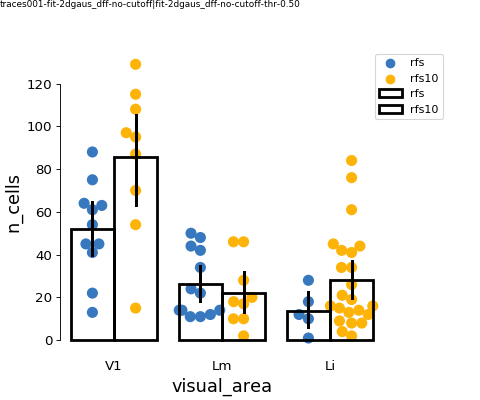

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'N_cells_fit_by_area_ALL')


In [180]:
r_df_nof
countdf_all = r_df_nof.groupby([ 'experiment', 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf_all.rename(columns={'cell': 'n_cells'}, inplace=True)


curr_metric = 'n_cells'

# g = sns.catplot(x='visual_area', hue='experiment',y='n_cells', data=countdf_all, 
#             kind='swarm', dodge=True, palette=bi_palette)
# Set x labels
fig, ax = pl.subplots(figsize=(6,5))
sns.swarmplot(x='visual_area', y='n_cells', hue='experiment', data=countdf_all, 
              dodge=True, palette=bi_palette, ax=ax, size=10, zorder=0,
             order=['V1', 'Lm', 'Li'])
sns.barplot(x='visual_area', y='n_cells', hue='experiment', data=countdf_all, ax=ax,
              facecolor=(1, 1, 1, 0), order=['V1', 'Lm', 'Li'],
            errcolor="k", edgecolor=('k', 'k', 'k'), linewidth=2.5)
sns.despine(bottom=True, trim=True)
ax.tick_params(which='both', axis='x', size=0)
label_figure(fig, data_id)
pl.legend(bbox_to_anchor=((1.2, 1)))
pl.subplots_adjust(right=0.8)


figname = 'N_cells_fit_by_area_ALL'
pl.savefig(os.path.join(compare_dir, '%s.svg' % figname))
print(compare_dir, figname)


<IPython.core.display.Javascript object>


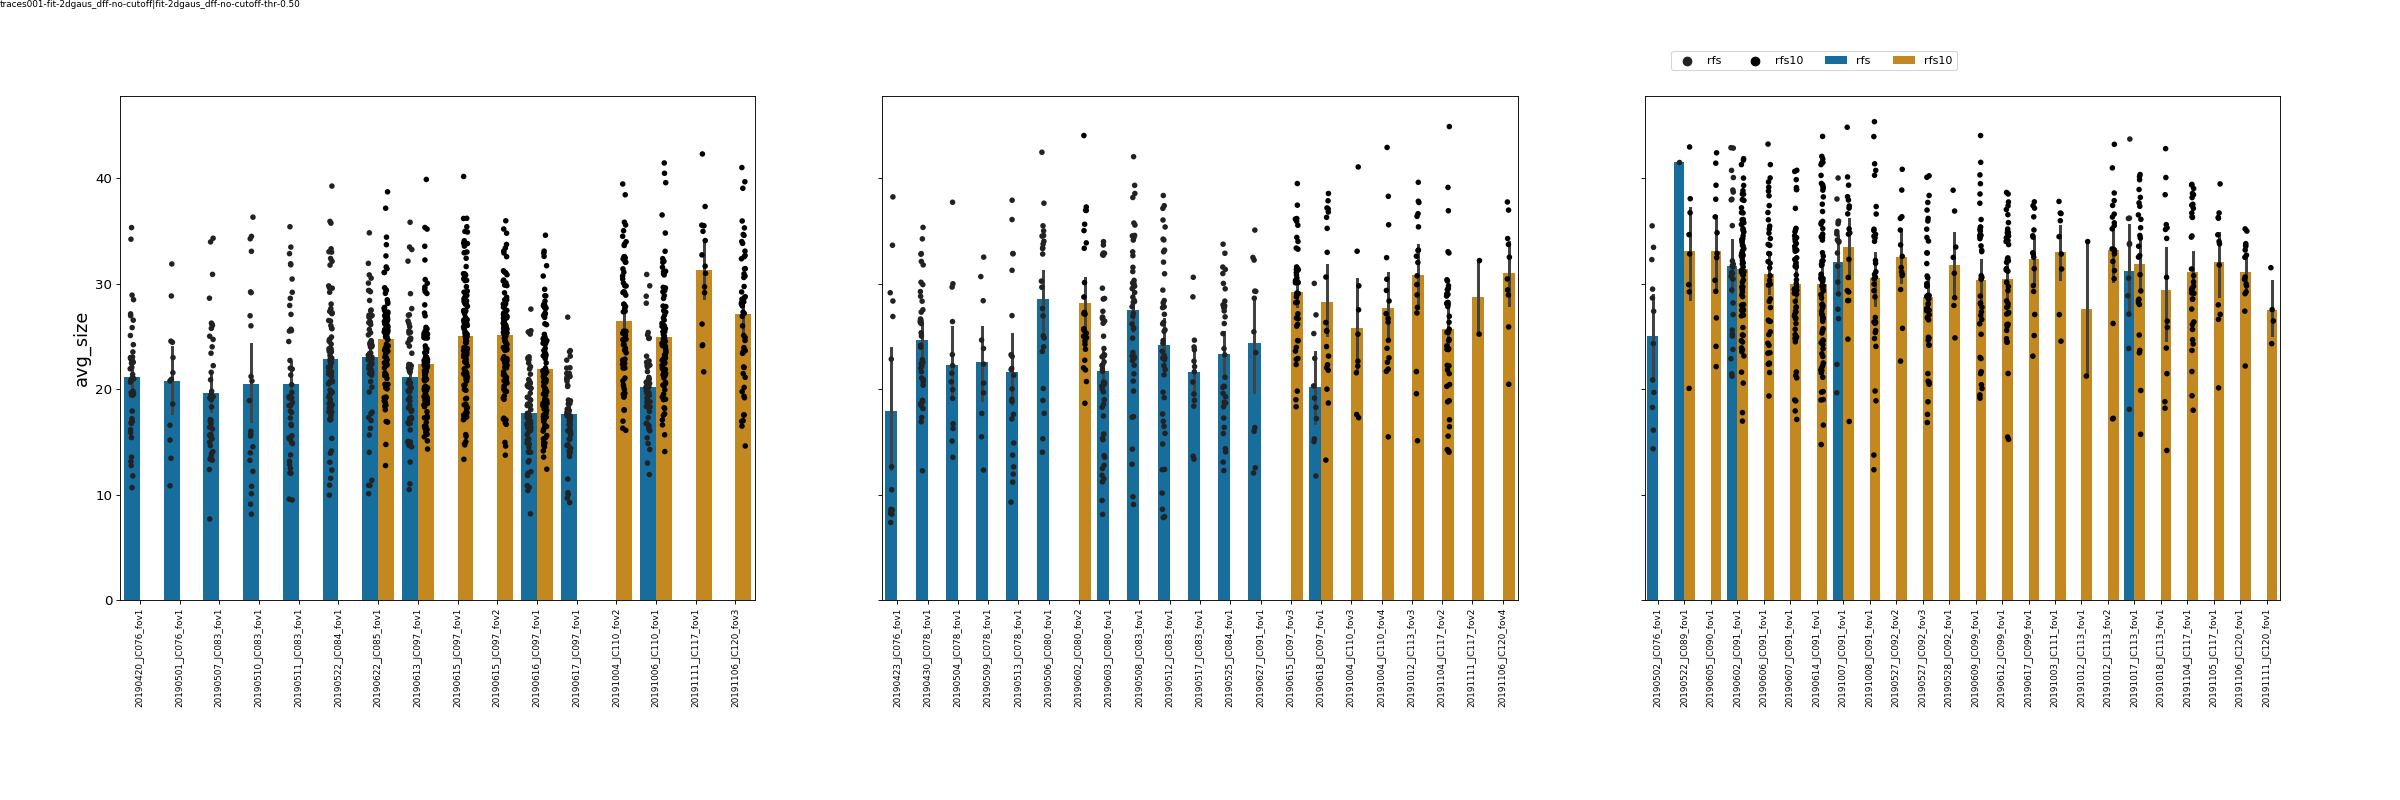

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'avg_size_by-dataset_by-experiment_ALL_fwhm')


In [92]:
curr_metric = 'avg_size'
sigma_str = 'fwhm' if scale_sigma else 'sigma'


fig, axes = pl.subplots(1,3, figsize=(30, 10), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    
    plotdf = r_df_nof[r_df_nof['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict_nof[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y=curr_metric, hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y=curr_metric, hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict_nof[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
        
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.5, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95, wspace=0.2)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_ALL_%s' % (curr_metric, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

## Drop repeats

In [98]:
#### How to deal with repeat FOVs (manual)
filter_by = 'drop_repeats'
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, traceid=traceid, fov_type=fov_type, state=state, stimulus='rfs')

Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [206]:
# filter_by = None

# #### Get metadata
# dsets = aggr.get_metadata(traceid=traceid, fov_type=fov_type, state=state, 
#                               filter_by=filter_by, stimulus='rfs')
# rfdata = dsets[dsets['experiment'].isin(['rfs', 'rfs10'])]
# rfdata.groupby(['visual_area', 'experiment']).count()

# #### Check for any datasets that need RF fits
# excluded_sessions = ['JC110_20191004_FOV1_zoom2p0x',
#                     'JC080_20190602_FOV1_zoom2p0x']
# rf_dpaths, nostats = get_fit_dpaths(rfdata, fit_desc=fit_desc, excluded_sessions=excluded_sessions)
# print(nostats)

# #### Get RF dataframe for all datasets (filter to include only good fits)
# all_df = aggregate_rf_data(rf_dpaths, verbose=False, scale_sigma=scale_sigma)
# all_df.groupby(['visual_area', 'experiment'])['datakey'].count()


# r_df = all_df[all_df['r2'] > fit_thr].copy().reset_index(drop=True)
# dkey_dict = dict((v, dict((dk, di) for di, dk in enumerate(vdf['datakey'].unique()))) \
#                  for v, vdf in r_df.groupby(['visual_area'])) 
# r_df['datakey_ix'] = [dkey_dict[r_df['visual_area'][i]][r_df['datakey'][i]] \
#                       for i in r_df.index.tolist()]    
    
    

Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 2
[]


visual_area  experiment
Li           rfs            31
             rfs10         386
Lm           rfs           166
             rfs10         250
V1           rfs           529
             rfs10         531
Name: datakey, dtype: int64

<IPython.core.display.Javascript object>


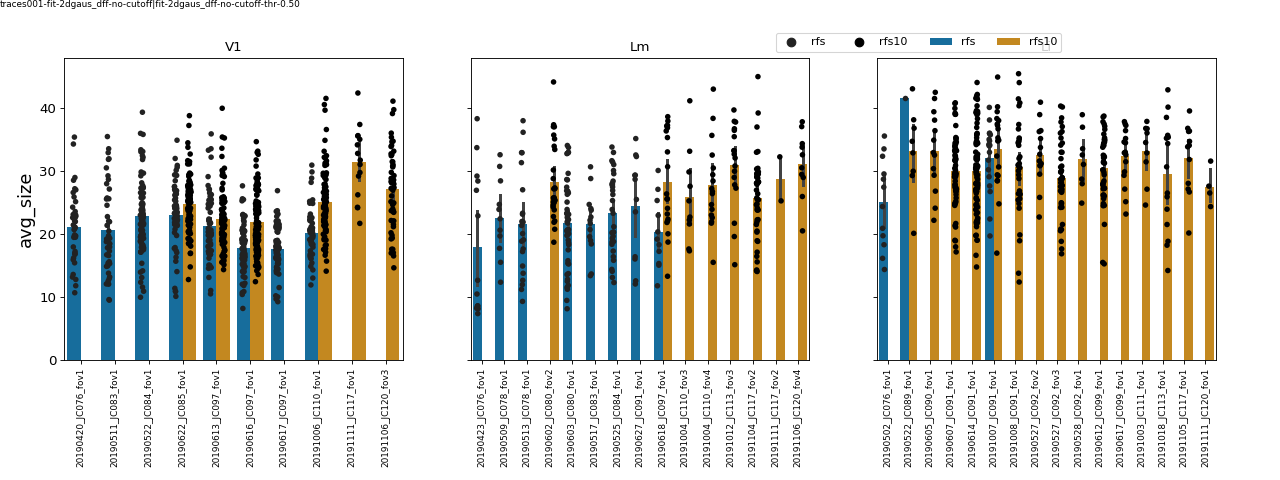

In [99]:
fig, axes = pl.subplots(1,3, figsize=(16, 6), sharey=True)
for ai, (ax, visual_area) in enumerate(zip(axes.flat, visual_areas)):
    plotdf = r_df[r_df['visual_area']==visual_area]
    curr_datakeys = sorted(plotdf['datakey'].unique(), key=natural_keys)
    
    #xvs = [dkey_dict[dk] for dk in curr_datakeys]
    plotdf['xv'] = [dkey_dict[visual_area][dk] for dk in plotdf['datakey']]
    
    sns.stripplot(x='xv', y='avg_size', hue='experiment', data=plotdf, ax=ax,
                 dodge=True, color='k')
    
    sns.barplot(x='xv', y='avg_size', hue='experiment', data=plotdf, ax=ax,
                 palette='colorblind')
    
    dkey_labels = [dk for dk, di in sorted(dkey_dict[visual_area].items(), key=lambda x: x[1])]
    
    ax.set_xticklabels(dkey_labels, rotation=90, fontsize=8)
    ax.set_xlabel('')
    if ai != 0:
        ax.set_ylabel('')
    
    ax.set_title(visual_area)
    
    if ai != 2:
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(0.56, 1.1), ncol=4)
pl.subplots_adjust(bottom=0.25, left=0.05, right=0.95)

label_figure(fig, data_id)
figname = '%s_by-dataset_by-experiment_%s_%s_2' % (curr_metric, filter_by, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))


In [100]:
all_df[all_df['r2']>0.5].groupby(['visual_area', 'experiment']).count()

NameError: name 'all_df' is not defined

In [173]:
all_df[(all_df['visual_area']=='Lm') & (all_df['experiment']=='rfs10')].count()

r2             250
sigma_x        250
sigma_y        250
theta          250
x0             250
y0             250
animalid       250
cell           250
datakey        250
experiment     250
session        250
visual_area    250
avg_size       250
dtype: int64

# Get datasets to analyze

In [101]:
# Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    
    vdf = g[g['experiment']==expname]
#     if len(vdf)==0:
#         vdf = g[g['experiment']==altname]
    rdf_list.append(vdf)
    
rdf = pd.concat(rdf_list)

# rdf = pd.concat([vdf[vdf['experiment']=='rfs10'] if v=='Li' else vdf[vdf['experiment']=='rfs'] \
#     for v, vdf in all_df.groupby(['visual_area'])])
rfdf = rdf[rdf['r2']>fit_thr]
rfdf.groupby(['visual_area']).count()

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,session,avg_size,datakey_ix
visual_area,,,,,,,,,,,,,
Li,386,386,386,386,386,386,386,386,386,386,386,386,386
Lm,151,151,151,151,151,151,151,151,151,151,151,151,151
V1,495,495,495,495,495,495,495,495,495,495,495,495,495


In [174]:
# Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    
    vdf = g[g['experiment']==expname]
#     if len(vdf)==0:
#         vdf = g[g['experiment']==altname]
    rdf_list.append(vdf)
    
rdf = pd.concat(rdf_list)

# rdf = pd.concat([vdf[vdf['experiment']=='rfs10'] if v=='Li' else vdf[vdf['experiment']=='rfs'] \
#     for v, vdf in all_df.groupby(['visual_area'])])
rfdf = rdf[rdf['r2']>fit_thr]
rfdf.groupby(['visual_area']).count()

,r2,sigma_x,sigma_y,theta,x0,y0,animalid,cell,datakey,experiment,session,avg_size
visual_area,,,,,,,,,,,,
Li,386,386,386,386,386,386,386,386,386,386,386,386
Lm,166,166,166,166,166,166,166,166,166,166,166,166
V1,495,495,495,495,495,495,495,495,495,495,495,495


In [104]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.py'>

## 1. Average RF size

<IPython.core.display.Javascript object>


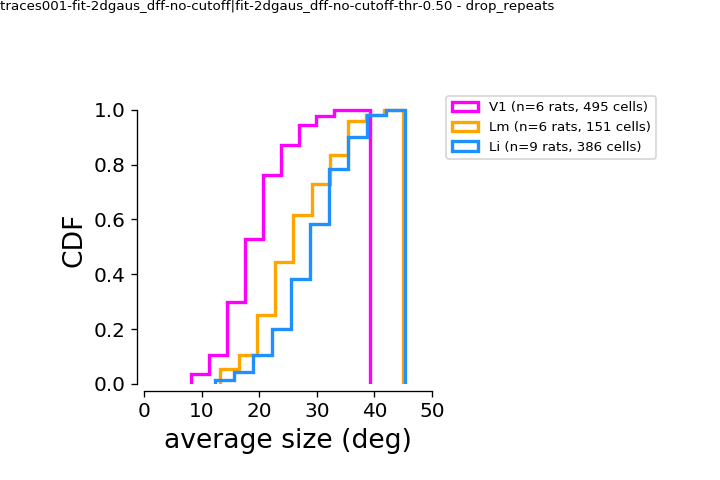

avg_size_drop_repeats_cdf


In [105]:
curr_metric = 'avg_size'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30
#for experiment, expdf in rfdf.groupby(['experiment']):

fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.compare_rf_size(rfdf, cdf=cdf, ax=ax, alpha=1, area_colors=area_colors)
ax.set_xlim([0, max_size])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, '%s - %s' % (data_id, filter_by))
figname = '%s_%s_%s' % (curr_metric, filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

## 2. Bar plot for fov averages

<IPython.core.display.Javascript object>


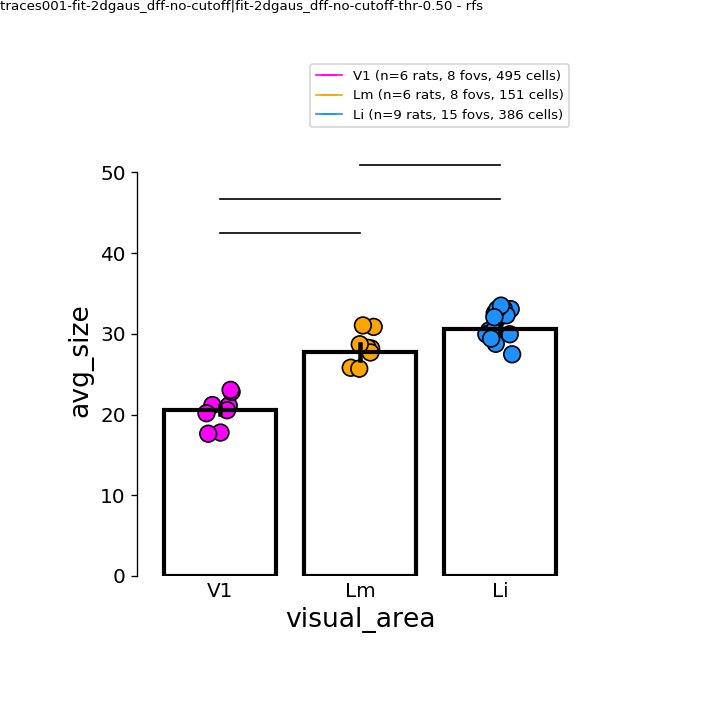

********* rfs - avg_size **********
[('V1', 'Lm')] Statistics=14960.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=22207.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=21656.000, p=0.000, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 6.1030881560329455e-29), (('V1', 'Li'), True, 4.4230317262061704e-85), (('Lm', 'Li'), True, 1.8175141291548127e-06)]
42.48
****************************
avg_size_fwhm_groupby-datakey_mean-fov_drop_repeats__multicomp-holm_ci


In [107]:
curr_metric = 'avg_size'
multi_comp_test = 'holm'
mean_metric = 'mean'
groupby = 'datakey'

# for experiment, expdf in rfdf.groupby(['experiment']):

# Average RF sizes for each FOV
if groupby is not None:
    grped = rfdf.groupby(['visual_area', groupby])
    group_str = 'groupby-%s' % groupby
else:
    grped = rfdf.groupby(['visual_area'])
    group_str = ''


if mean_metric == 'median':
    mean_sizes = grped.median()['avg_size'].reset_index()
else:
    mean_sizes = grped.mean()['avg_size'].reset_index()

fig, ax = pl.subplots(figsize=(6,6), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.barplot(x="visual_area", y=curr_metric, data=rfdf, 
            ax=ax, order=visual_areas, ci=95,
            errcolor="k", edgecolor=('k', 'k', 'k'), 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.stripplot(x='visual_area', y=curr_metric, data=mean_sizes, 
              zorder=0,
              ax=ax, #hue='cond',
              s=10, palette=area_colors, 
              order=visual_areas, 
              color=(1,1,1,0), 
              dodge=True,
              #facecolor=(1,1,1,0),
              edgecolor='k',
              marker='o',linewidth=1)

print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(rfdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax=ax)
print("****************************")

#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True)
ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(rfdf, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_%s_%s_%s-fov_%s__multicomp-%s_ci' % (curr_metric, sigma_str, group_str, mean_metric, filter_by, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

In [108]:

print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(mean_sizes, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
#annotate_stats_areas(statresults, ax)
print("****************************")

********* rfs - avg_size **********
[('V1', 'Lm')] Statistics=0.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=0.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=18.000, p=0.004, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 0.0009391056991171899), (('V1', 'Li'), True, 0.00018401959621917283), (('Lm', 'Li'), True, 0.0036941768465627383)]
****************************


## Distn of all rf sizes

<IPython.core.display.Javascript object>


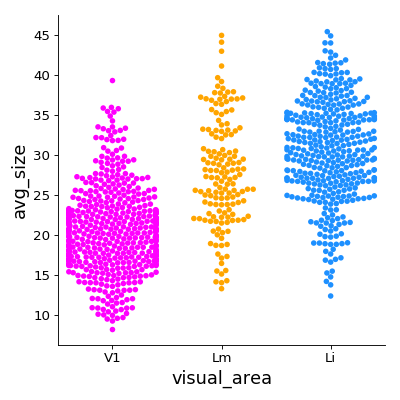

avg-size-distns_fwhm_combine-all_by-area_swarm


In [181]:
plot_kind = 'swarm'
fg = sns.catplot(x="visual_area", y="avg_size", data=rfdf,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = 'avg-size-distns_%s_combine-all_by-area_%s' % (sigma_str, plot_kind)
fg.fig.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))
print(figname)

## Look at N cells fit 

In [182]:
countdf = rfdf.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)


<IPython.core.display.Javascript object>


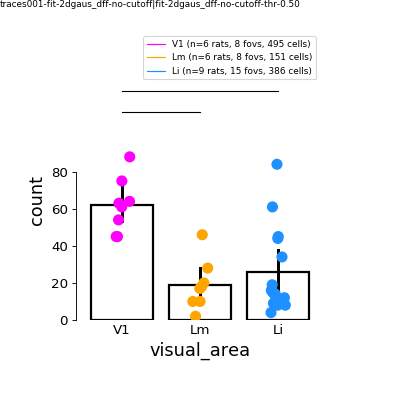

********* rfs - n_cells **********
[('V1', 'Lm')] Statistics=2.000, p=0.001, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=11.500, p=0.001, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=59.000, p=0.487, ... Same distribution (fail to reject H0)
[(('V1', 'Lm'), True, 0.0028736476934448779), (('V1', 'Li'), True, 0.0028736476934448779), (('Lm', 'Li'), False, 0.48712006533324409)]
112.08
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats', 'n_cells_avg-fov_drop_repeats__multicomp-holm')


In [183]:
curr_metric = 'n_cells'
fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')


#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(rfdf, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


print("********* %s - %s **********" % (experiment, curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax=fg.ax)
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s_avg-fov_%s__multicomp-%s' % (curr_metric, filter_by, multi_comp_test)
fg.fig.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(genstats_dir, figname)


## All fit params

In [571]:
params

['x0', 'y0', 'theta', 'sigma_x', 'sigma_y', 'avg_size']

<IPython.core.display.Javascript object>


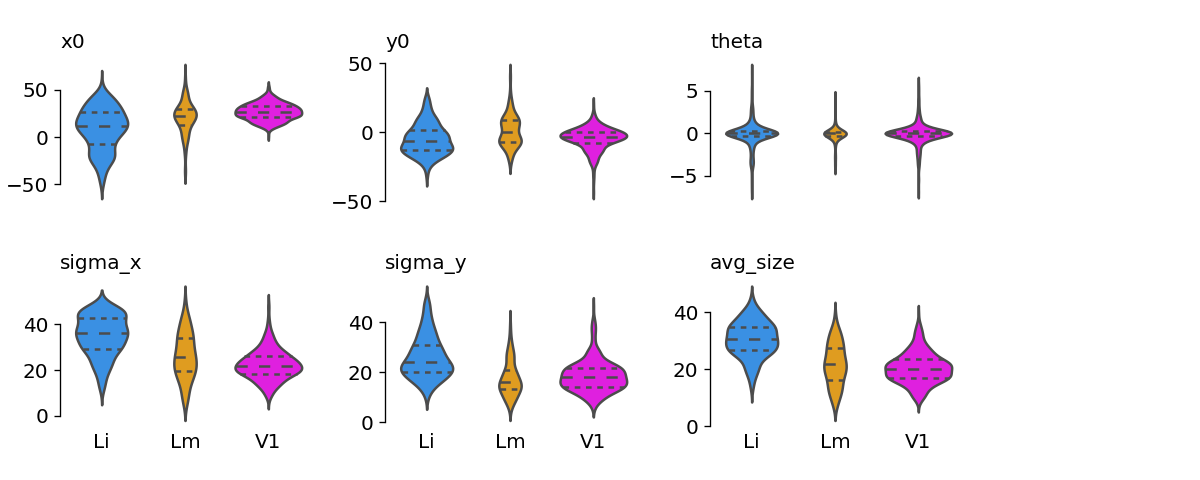

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001-fit-2dgaus_dff-no-cutoff/general-stats/rfs_v_rfs10', 'all-metrics_drop_repeats_fwhm')


In [216]:
plot_type = 'violin'

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=rfdf, ax=ax,
                      palette=area_colors,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=rfdf, ax=ax,
                      palette=area_colors, dodge=True)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)
    sns.despine(trim=True, ax=ax, bottom=True)
    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_%s_%s' % (filter_by, sigma_str)
pl.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(compare_dir, figname)    